In [ ]:
# problem statement:Implement a simple GAN to generate synthetic images similar to those in the MNIST dataset. Train the GAN and visualize the generated images. Discuss the challenges faced during training and how you addressed them

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


In [3]:
# Hyperparameters
latent_dim = 64
img_dim = 28 * 28  # 784
batch_size = 64
learning_rate = 0.0002
num_epochs = 100

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
generator = Generator(input_dim=latent_dim, output_dim=img_dim).to(device)
discriminator = Discriminator(input_dim=img_dim).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)


In [5]:
for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        # Prepare real images and labels
        real_imgs = real_imgs.view(-1, img_dim).to(device)
        batch_size = real_imgs.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the Discriminator
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)
        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    # Display progress
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")


Epoch [1/100], d_loss: 0.1107, g_loss: 5.1762
Epoch [2/100], d_loss: 0.5391, g_loss: 3.6928
Epoch [3/100], d_loss: 0.3228, g_loss: 1.9624
Epoch [4/100], d_loss: 0.2101, g_loss: 2.5870
Epoch [5/100], d_loss: 0.5531, g_loss: 2.1586
Epoch [6/100], d_loss: 0.3025, g_loss: 3.1703
Epoch [7/100], d_loss: 0.3382, g_loss: 4.9261
Epoch [8/100], d_loss: 0.6183, g_loss: 7.6741
Epoch [9/100], d_loss: 0.4192, g_loss: 4.6796
Epoch [10/100], d_loss: 0.1147, g_loss: 4.9140
Epoch [11/100], d_loss: 0.1547, g_loss: 5.2701
Epoch [12/100], d_loss: 0.2641, g_loss: 4.5443
Epoch [13/100], d_loss: 0.1529, g_loss: 4.0794
Epoch [14/100], d_loss: 0.1303, g_loss: 6.1086
Epoch [15/100], d_loss: 0.2050, g_loss: 3.9588
Epoch [16/100], d_loss: 0.3021, g_loss: 3.9988
Epoch [17/100], d_loss: 0.3422, g_loss: 5.3502
Epoch [18/100], d_loss: 0.3408, g_loss: 4.6893
Epoch [19/100], d_loss: 0.2523, g_loss: 5.1286
Epoch [20/100], d_loss: 0.1639, g_loss: 4.9254
Epoch [21/100], d_loss: 0.2373, g_loss: 2.8907
Epoch [22/100], d_loss

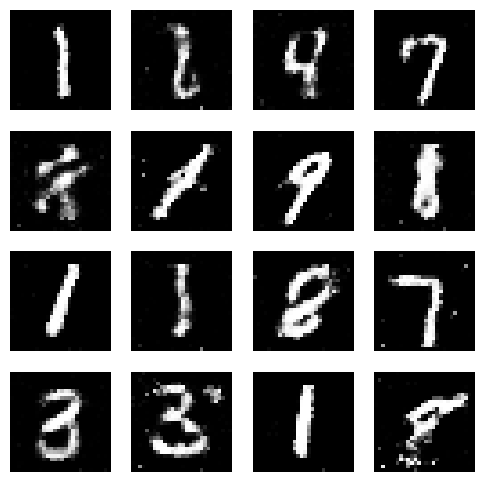

In [6]:
def show_generated_images():
    noise = torch.randn(16, latent_dim).to(device)
    generated_imgs = generator(noise).view(-1, 1, 28, 28)
    generated_imgs = generated_imgs.cpu().detach()

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_imgs[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

show_generated_images()
